#### Notebook modified from the original version by `Lukas Mosser` and `Navjot Kukreja`

In [2]:
%pylab inline
import torch
import torch.nn as nn

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size -
    torch.backends.cudnn.enabled   = False

    return True

Populating the interactive namespace from numpy and matplotlib


You can check the [`backends.cudnn` documentation](https://pytorch.org/docs/stable/backends.html) for more info on how to tune your [cuDNN library](https://docs.nvidia.com/deeplearning/cudnn/index.html) (and other backends).

In [3]:
!pip install torch

# ACSE Module 8 - Practical - Morning Session 2 Solutions:
# Pytorch, Automatic Differentiation, Optimization

## Objectives of the day:

- Understand optimisation in the context of Machine Learning(理解机器学习中的优化)

- Understand the mechanics of PyTorch to train a network (optimisation problem)(理解PyTorch训练网络(优化问题)的机制)

<br>

## Optimisation, training and backpropagation concepts in supervised learning
<hr>
<br>

While it is possible to train an unsupervised network (as we will see when we visit autoencoders), we will focus today on supervised learning.(虽然训练无监督网络是可能的(我们将在访问自动编码器时看到)，但我们今天将重点放在监督学习上)

<br>

Assume we have a fully connected neural network designed to classify hand-written numbers from the MNIST dataset:

<br>

<img src="https://thumbs.gfycat.com/AdorableJoyfulLemming-max-1mb.gif" alt="network" width="800"/>

<br>

The parameters $\theta_{ij}^{(k)}$ of the network control how well the network assigns a digit to its correct class, and as you can see the network in the gif above already knows what it's doing as the softmax activation function in the last layer provides the largest probability to the correct class (7).（参数θ控制网络如何分配一个数字给一个类，就像你可以看到图上的网络知道它在做什么，就像在最后一层的softmax激活函数为正确的类提供了最大的概率）

But when we attack a new problem, we only have a dataset and the intention to use a neural network to solve the problem. We will not talk today about how to choose the best network architecture (that is, how many hidden layers, how many neurons per layer, what activation functions to use, etc, as this will be covered in future sesions).(但是当我们解决一个新问题时，我们只有一个数据集和使用神经网络来解决问题的意图。我们今天不讨论如何选择最好的网络架构(即，有多少隐藏层，每层有多少神经元，使用什么激活功能，等等，这将在以后的课程中讨论)。
)

Let's assume for now that we have decided to use a particular network architecture. This network is untrained, and by that we mean that since it has never seen the data, we have no idea of what the network parameters should be. The common approach is then, assign random numbers to this parameters and see what happens.(现在让我们假设我们已经决定使用特定的网络体系结构。这个网络是未经训练的，我们的意思是，因为它从未见过数据，我们不知道网络参数应该是什么。常见的方法是，给这些参数分配随机数，然后看看会发生什么。)

This happens:

<br>

<img src="https://thumbs.gfycat.com/ContentDarlingCub-size_restricted.gif" alt="network" width="800"/>

<br>

So the question now is how do we improve these parameters so that the network does what we want (which is to correctly classify my digits in this case)? The answer is to train the network.（在的问题是，我们如何改进这些参数，让网络做我们想做的事情(在这种情况下，就是正确地分类我的数字)?答案是训练网络）

Training means that we will use data for which we know the answer to modify the parameters $\theta$ of our network by defining a loss function that captures the accuracy of the predictions of our network.（训练意味着我们将使用已知答案的数据来修改我们网络的参数𝜃，通过定义一个损失函数来捕获我们网络预测的准确性）

Why do we use local optimisation techniques (based on gradient descent methods and variations) to train our networks? Remember how many parameters where there in the network from yesteraday's talk? （为什么我们要使用局部优化技术(基于梯度下降方法和变化)来训练我们的网络?还记得昨天讲过的网络中有多少参数吗）

The loss function defines a hypersurface in a multi-dimensional space that has as many dimensions as there are network parameters. This hypersurface is known as the [solution space, the feasible region, the search space or the feasible set](https://en.wikipedia.org/wiki/Feasible_region).（损失函数定义了一个多维空间中的超曲面，这个超曲面的维数与网络参数的维数相同。这个超曲面被称为解空间、可行域、搜索空间或可行集）

So the goal of training is to find the lowest point in this solution space. In a very simple case with two dimensions (two network parameters) we will do this:
（训练的目的是找到这个解空间中的最低点。在一个二维(两个网络参数)的非常简单的情况下，我们将这样做:）
<img src="https://camo.githubusercontent.com/8ea43a1f70612fe0be12346955ed5befd10c6bbdf2e850d04fe3bf865d25445d/68747470733a2f2f707669676965722e6769746875622e696f2f6d656469612f696d672f70617274312f6772616469656e745f64657363656e742e676966" alt="optimisation" width="800"/>

<br>

And in order to achieve this we will use **backpropagation**.

**Backpropagation** is a method that will let us improve our network parameters by iteratively updating them in a direction that reduces the magnitude of the loss.（为了达到这个目的，我们将使用反向传播。反向传播是一种可以让我们改进网络参数的方法，通过迭代更新它们的方向，以减少损失的幅度。）

And now, it (hopefully) has become clearer why we use local optimisation: we can afford to compute the value of the loss for a particular set of $\theta$ values, as well as the gradient of the loss with respect to these $\theta$ values using backpropagation. But using a global method (like Monte Carlo optimisation) would be unaffordable because that would require to run forward passes of the network a ridiculously large number of times (remember we are in very large dimensional spaces). （现在，我们(希望如此)已经清楚了为什么要使用局部优化:我们可以使用反向传播计算特定的𝜃值的集合的损失值，以及这些𝜃值的损失梯度。但是使用全局方法(比如蒙特卡罗优化)是无法承受的，因为这需要将网络向前传递次数很多(记住，我们是在非常大的维度空间中)。）

To avoid having to manually code a lot of the functionalities required to implement our networks, we will use PyTorch.（为了避免手工编写实现网络所需的许多功能，我们将使用PyTorch）

## PyTorch
<hr>

[Pytorch](https://pytorch.org) is a (almost) drop-in replacement to numpy functionality but with added automatic differentiation capabilities.（加入了自动微分功能）  

## Awesome [Pytorch](https://www.pytorch.org) functionalities and where to find them:

- [torch.Tensor](https://pytorch.org/docs/stable/tensors.html): Fundamental Tensor operations (matmul, sum, mean, transpose, ...)
- [torch.nn](https://pytorch.org/docs/stable/nn.html): Specialised functions for implementing (deep) neural networks
    - [torch.nn.DataParallel](https://pytorch.org/docs/stable/nn.html#dataparallel-layers-multi-gpu-distributed): Parallel and Distributed Computing
    - [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity): Sigmoid, Tanh, ReLU, ...
    - [Linear Layers](https://pytorch.org/docs/stable/nn.html#linear-layers)
    - [Convolutional Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
    - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions): MSE-Loss, CrossEntropyLoss, ...
- [torch.optim](https://pytorch.org/docs/stable/optim.html): First and Second-order Gradient Descent Optimizers
- [torch.autograd](https://pytorch.org/docs/stable/autograd.html): Automatic Differentiation Functionality
- [torch.distributions](https://pytorch.org/docs/stable/distributions.html): Probability Distributions
- [torch.utils](): Utility functions
    - [torch.utils.data](https://pytorch.org/docs/stable/data.html): Contains useful methods to load and handle data
- [torchvision](https://pytorch.org/vision/stable/index.html): Datasets, Pre-trained Models, Transforms

## Task 0: Basic Pytorch Tensor Operations 

### 0.1: setting a seed and declaring variables (tensors，即实际上是一个多维数组)

In [4]:
#Setting the random seed of torch, numpy and python's random module
set_seed(42) # so that we all get the same results (that's all it does)

#Declare a scalar value
a = torch.Tensor(1) #具有一个随机值的数组
print(a, a.item())

#Declare a tensor like another tensor - creates tensor of the same shape
b = torch.zeros_like(a) #像a格式一样的值为0的数组
print(b, b.item())

#Create a torch.Tensor from a numpy array - doesn't copy memory! :)
c = torch.from_numpy(np.array(range(42))) 
print(c)

#Get back the underlying numpy array 返回张量c的底层数组
print(c.numpy())

tensor([-13483264.]) -13483264.0
tensor([0.]) 0.0
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


### 0.2: Create a random array

In [ ]:
#Create a tensor of Gaussian (0-mean, 1-std. dev.) values 返回一个张量，其中充满均值为0、方差为1的正态分布的随机数
m = torch.randn(1, 1, 28, 28)
print(m.size())

torch.Size([1, 1, 28, 28])


### 0.3: Plotting Pytorch Tensors

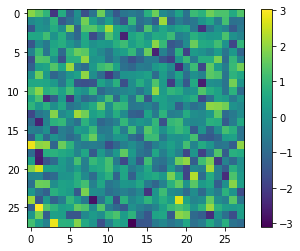

In [ ]:
plt.imshow(m[0, 0, :, :]) # equal to plt.imshow(m[0,0])
plt.colorbar()

### 0.3: Using a GPU
We can also make use of a GPU (if we have one) by specifying ```.cuda()``` on any Tensors and later Modules.

[torch.cuda](https://pytorch.org/docs/stable/cuda.html) package documentation.

In [5]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
#Move tensors around using the .to(device) command
tensor_on_device = torch.ones(1).to(device)
print(tensor_on_device.device)

Cuda installed! Running on GPU!
cuda:0


`cuda:0` means that the tensor we have moved to the device is on the device `cuda:0` (which is the GPU we are using).

### 0.4: Pytorch Autograd with simple functions

Pytorch allows us to write pythonic functions and use them in our computational graph.（Pytorch允许我们编写python函数并在计算图中使用它们。）

In [7]:
a = torch.ones(1, requires_grad=True)*np.pi
print(a)
def f(x):
    return torch.sin(x)
y = f(a)
print(a.item(), y.item())

# We can explicitly calculate gradients of a function with respect to a parameter or set of parameters:（我们可以明确地计算一个函数关于一个参数或一组参数的梯度，这里计算y关于a的梯度）
print("The derivative is: ", torch.autograd.grad(y, a)[0].item()) # [0] because .grad returns a tuple and we need to extract the value (it only has one element 这里只有一个参数所以是[0])
# print("The derivative is: ", torch.autograd.grad(y, a)[0].item()) 


tensor([3.1416], grad_fn=<MulBackward0>)
3.1415927410125732 -8.742277657347586e-08
The derivative is:  -1.0


### 0.5: **Pytorch Modules** (this is important as you will use `nn.Module` often)

We will make a simple parametric parabola as a Pytorch module. (我们将制作一个简单的参数抛物线作为Pytorch模块。) 
We don't need to write a backward (derivative) for pytorch modules as they are (我们不需要为pytorch模块编写反向(导数))

In [8]:
class ParametricParabola(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.a = torch.nn.Parameter(torch.ones(1, requires_grad=True)*a)
        self.b = torch.nn.Parameter(torch.ones(1, requires_grad=True)*b)

    def forward(self, x):
        return self.a*x*x+self.b

[a good stackoverflow explanation on supercharing classes](https://stackoverflow.com/questions/576169/understanding-python-super-with-init-methods) (if you are curious to know how it works in detail, and **completely optional**).

Let's inspect what the parameters are:()

In [9]:
f = ParametricParabola(0.5, 2)
print(f.a)
print(f.b)

Parameter containing:
tensor([0.5000], requires_grad=True)
Parameter containing:
tensor([2.], requires_grad=True)


We can also compute gradients for this example with respect to the parameters: 我们计算关于参数的梯度

In [10]:
f.zero_grad() #this resets all the gradients within the computational graph.
# 我们现在不需要关于x的梯度，因此设置为False。我们要看关于抛物线参数的梯度
x = torch.ones(1, requires_grad=False)*np.pi # we don't need the grad with respect to x now, we will look at the grad with respect to the parameters of the parabola.
y = f(x) # you need to call it like this to make sure that torch takes care of the registered hooks. 这里调用是为了登记？ Calling it as a method does not do that.*
y.backward() #call autograd to compute all partial derivatives with respect to all Parameters that require gradients 调用autograd来计算所有需要梯度的参数的偏导数
print(f.a.grad, f.b.grad)
print(f.a.grad.item(),f.b.grad.item()) # use .item() to print the value 使用.item()来打印值

tensor([9.8696]) tensor([1.])
9.86960506439209 1.0


What do you think the values printed are?

\*[more about hooks here](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/) (if you are interested, and again **absolutely optional**)

### 0.6 Using Pytorch's Optimization functionality

We can use methods from ```torch.optim``` to optimize parameters. 我们可以使用```torch.optim```来优化参数
We use this here to find the global minimum of our parabola with gradient descent. 我们在这里使用这个来用梯度下降法求抛物线的全局最小值


In [ ]:
set_seed(42)
x = torch.from_numpy(np.array([50])).float() #创建一个长度为50的float随机数组
x.requires_grad = True  # now we do need the grad with respect to x, as we are optimising for it. 因为这里我们使用梯度下降来找到某个x使得抛物线取最小值，所以是关于x的梯度，所以x设置为需要梯度的
f = ParametricParabola(2., 0.) #抛物线参数：a=2，b=0
optimizer = torch.optim.SGD([x], lr=1e-2) # also, play with the learning rate to see how it affects the results
for i in range(1000):
    optimizer.zero_grad() # 设置优化后张量的所有梯度为0
    value = f(x)
    value.backward() #调用autograd来计算关于所有需要梯度的参数的偏导数
    optimizer.step() #执行单个优化步骤
    if i % 100 == 99 or i == 0 or i == 1 or i == 10 or i == 50:
        print("Iteration ", i, " Functional value: ", value.item(), '      x= ', x.item())

Iteration  0  Functional value:  5000.0       x=  48.0
Iteration  1  Functional value:  4608.0       x=  46.08000183105469
Iteration  10  Functional value:  2210.012451171875       x=  31.911968231201172
Iteration  50  Functional value:  84.35159301757812       x=  6.234518051147461
Iteration  99  Functional value:  1.5440950393676758       x=  0.8435158729553223
Iteration  199  Functional value:  0.00043946102960035205       x=  0.014230377972126007
Iteration  299  Functional value:  1.250740098157621e-07       x=  0.00024007103638723493
Iteration  399  Functional value:  3.559699757182955e-11       x=  4.050073584949132e-06
Iteration  499  Functional value:  1.0131178970025027e-14       x=  6.832603816064875e-08
Iteration  599  Functional value:  2.883410581065414e-18       x=  1.1526819498897112e-09
Iteration  699  Functional value:  8.206407158350303e-22       x=  1.944611138782193e-11
Iteration  799  Functional value:  2.3356080922195324e-25       x=  3.2806220305429956e-13
Iterat

### What did we just optimised for here? Network parameters?

<br>

####NOTE: difference between `.grad` and `.backward`:

The difference is that `.grad()` is returning the gradients to you.
While `.backward()` is populating the `.grad` field on the different leaf Tensors that were used to compute y.

In particular, this `.grad` field is used by the optimizers to update the weights. So **if you use `.grad()` you will need to populate these fields yourself based on the gradients it returned before calling optimizer.step()**.

[reference](https://discuss.pytorch.org/t/whats-the-difference-between-torch-autograd-grad-and-backward/94638)

## Task 1: Plotting the Ackley Function using Numpy

The [Ackley](https://en.wikipedia.org/wiki/Ackley_function) function is a common test problem for optimization problems with many local minima:（Ackley函数是求解具有多个局部极值的优化问题的常用测试问题）
\begin{equation*}
f(x, y)= -20 exp [-0.2\sqrt{0.5(x^2+y^2)}]-exp[0.5\{cos(2 \pi x) + cos(2 \pi y)\}]+ e +20
\end{equation*}

In the following problem tasks we will use pytorch to evaluate this function numerically and study its behavior under common gradient descent techniques.

- 1.1: Define the Ackley-Function as a python function
- 1.2: Use your previously defined function to plot the function in 3d in the range $(x, y)\in [-5, 5]$
- 1.3: Use your previously defined function Plot the function in 3d in the range $(x, y) \in [-32, 32]$
- 1.4: What do you observe about this function? Why do you think this function is a test problem for optimization?

### 1.1: Define the Ackley-Function as a python method 

In [11]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def ackley(x, y):
    sum_sq_term = -20 * np.exp(-0.2*np.sqrt(0.5*(x*x+y*y)))
    cos_term = -np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
    value = sum_sq_term+cos_term+np.exp(1)+20
    return value

### 1.2: Use your previous defined method to plot the function in 3d in the range $(x, y)\in [-5, 5]$

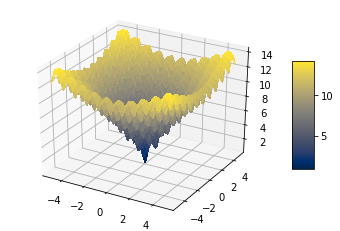

In [12]:
def plot_ackley_3d(x, y):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    x, y = np.meshgrid(x, y)
    
    z = ackley(x, y)

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.cividis,
                                   linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
plot_ackley_3d(x, y)

### 1.3: Use your previous defined method Plot the function in 3d in the range $(x, y) \in [-32, 32]$

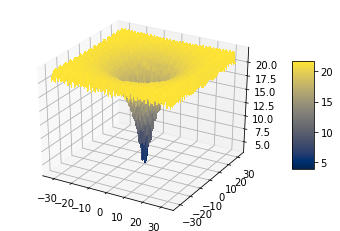

In [13]:
x = np.linspace(-32, 32, 100)
y = np.linspace(-32, 32, 100)

plot_ackley_3d(x, y)

### 1.3: Use your previous defined method Plot the function in 3d in the range $(x, y) \in [-2, 2]$

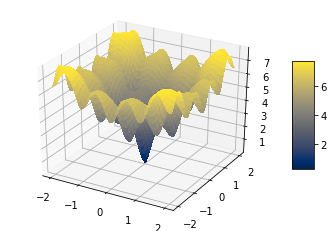

In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

plot_ackley_3d(x, y)

### 1.4: What do you observe about this function? Why do you think this function is a test problem for optimization?

Plot it again as a contour to highlight its non-convex nature

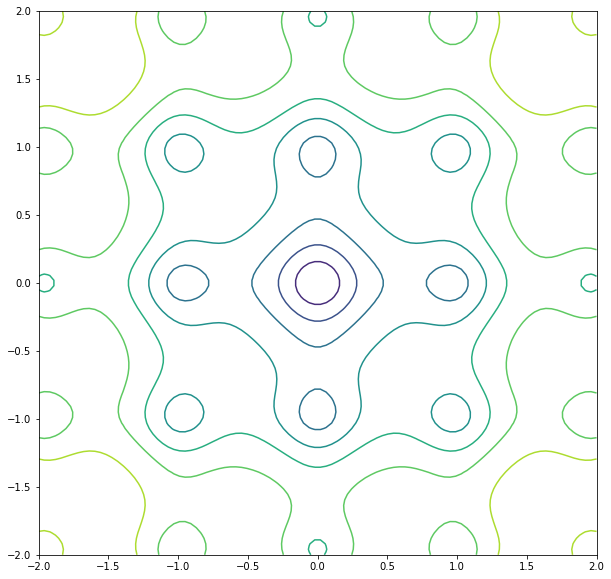

In [14]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = ackley(X,Y)
plt.figure(figsize=(10,10))
plt.contour(X,Y,Z)

## Task 2: The Ackley Function in Pytorch, Autograd and Gradient Descent

- 2.1: Define the Ackley-Function as a pytorch nn.Module class
- 2.2: Try to find the global minimum (solution: 0., 0.) of the Ackley function with Gradient Descent (```torch.optim.SGD```) from a random starting position. Use torch.randn to obtain a sample from a Gaussian.（从一个随机起始点尝试去找到全局最小值，使用梯度下降（```torch.optim.SGD```），使用torch.randn从高斯获得一个随机采样）
    - Store and plot the corresponding function value as a function of the iteration number (ackley(x) vs. iteration)
    - Store and plot the norm of the gradients during optimization.
- 2.3: For 10 random starting positions (```torch.randn```) plot the Ackley function in 2D and the optimization trajectories together:（对于10个随机起始位置(```torch.randn```)，在2D中绘制Ackley函数和优化轨迹）
    - Do you reach a global minimum?
    - What do you observe for the various optimization trajectories.
    
### 2.1: Define the Ackley-Function as a pytorch nn.Module class（定义Ackley-Function作为一个pytorch nn.Module类）

In [16]:
class Ackley(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, coords):
        x = coords[:, 0] # they are arrays that can be computed in groups
        y = coords[:, 1] # instead of one at a time as we defined before
        sum_sq_term = -20 * torch.exp(-0.2*torch.sqrt(0.5*(x*x+y*y))) # = -20 * np.exp(-0.2*np.sqrt(0.5*(x*x+y*y))) 
        cos_term = -torch.exp(0.5*(torch.cos(2*np.pi*x)+torch.cos(2*np.pi*y))) # -np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
        value = sum_sq_term+cos_term+np.exp(1)+20 # no need to keep track with torch here, np is fine (no parameter in the call)
        return value


### 2.2: Find the global minimum (solution: 0., 0.) of the Ackley function with Gradient Descent 

and plot the functional value and the gradient norm

current X = 0.326690, current Y = 0.326690
current X = 0.231851, current Y = 0.231851
current X = 0.123907, current Y = 0.123907
current X = 0.033870, current Y = 0.033870
current X = 0.001632, current Y = 0.001632
current X = -0.000113, current Y = -0.000113



Text(0, 0.5, 'Gradient Norm')

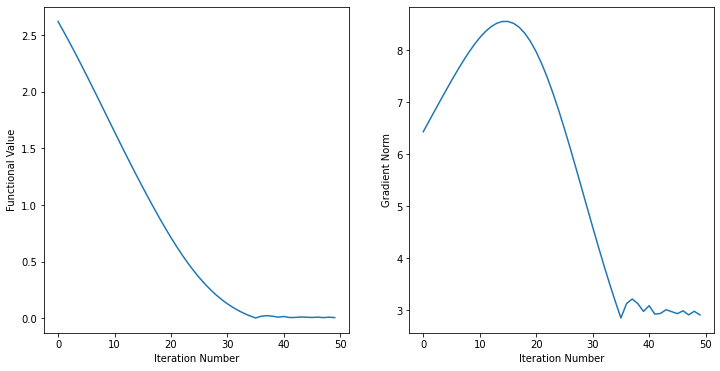

In [17]:
set_seed(42)
#set_seed(621)   
ackley_torch = Ackley()

coords = torch.randn(1, 2, requires_grad=True) # only one pair 一个点
optimizer = torch.optim.Adam([coords], lr=1e-2, betas=(0.5, 0.9)) # new optimiser introduced here
steps = [] # initialise steps and grads as
grads = [] # empty lists
for i in range(50):
    optimizer.zero_grad() # remember to reset the gradient information
    f = ackley_torch(coords)
    f.backward()
    optimizer.step() 
    steps.append(f.detach().numpy().copy()) # keep track of the functional value 记录函数值
    grads.append(coords.grad.norm().detach().numpy().copy()) # keep track of the gradients 记录梯度
    if i % 10 == 9 or i == 0:
      print('current X = {0:5f}, current Y = {0:5f}'.format(coords[0,0].item(), coords[0,1].item()))

print('')    
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(steps)
ax[0].set_xlabel("Iteration Number")
ax[0].set_ylabel("Functional Value")
ax[1].plot(grads)
ax[1].set_xlabel("Iteration Number")
ax[1].set_ylabel("Gradient Norm")

### Again, what have we just optimised?

<br>

Documentation for the [Adam optimiser](https://pytorch.org/docs/stable/optim.html)

### 2.3: For 10 random starting positions (```torch.randn```) plot the Ackley function in 2D and the optimization trajectories together. 10个随机起始位置开始

Plot the trajectories on top of the contour plot, but use [contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) this time.

In [18]:
set_seed(42)
ackley_torch = Ackley() # define your function (and functional really!)

attempts = []
for j in range(10):  # let's start just with 1 point and see what happens, then increase to 10 and then to a 100.
    coords = torch.randn(1, 2)*2
    coords.requires_grad = True
    optimizer = torch.optim.SGD([coords], lr=1e-2) # change it to 1, 1e-2, and 1e-3 and analyse the behaviour
    steps = [coords.detach().numpy().copy()]
    for i in range(50):
        optimizer.zero_grad()
        f = ackley_torch(coords)
        f.backward()
        optimizer.step()
        steps.append(coords.detach().numpy().copy())
    attempts.append(steps)

(-3.0, 3.0)

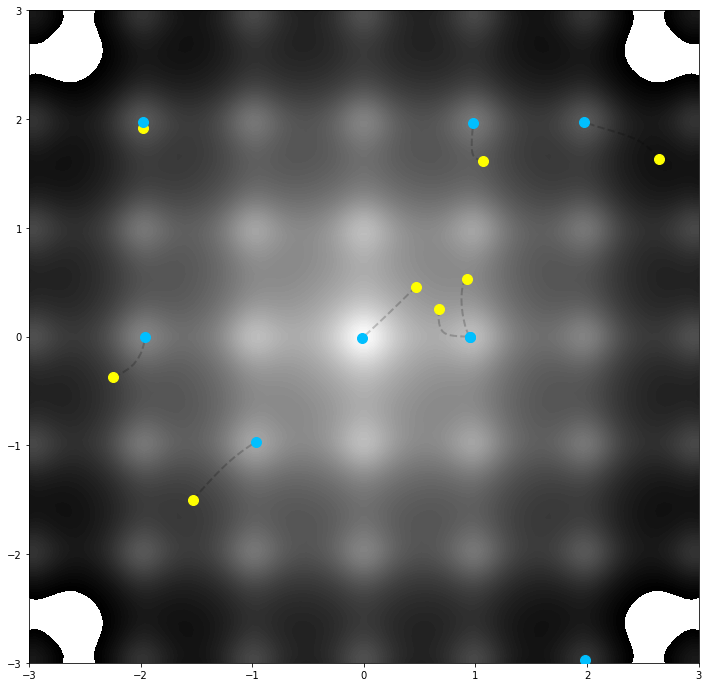

In [ ]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Make data.
x, y = np.meshgrid(x, y)

z = ackley(x, y)

# Plot the surface.
surf = ax.contourf(x, y, z, np.linspace(0, 10, 100), cmap=cm.gray_r)
for a in attempts:
    steps_np = np.array(a)[:, 0, :]
    ax.plot(steps_np[:, 0], steps_np[:, 1], linewidth=2, c="black", linestyle="--", alpha=0.2)
    
for a in attempts:
    steps_np = np.array(a)[:, 0, :]
    ax.scatter(steps_np[[0], 0], steps_np[[0], 1], marker="o", color="yellow", s=100, zorder=100)
    ax.scatter(steps_np[[-1], 0], steps_np[[-1], 1], marker="o", color="deepskyblue", s=100, zorder=100)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

<br>

----

<br>

## Definition of the half-moon dataset

In [19]:
import torch
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score


def make_train_test(batch_size, batch_num, test_size, noise=0.05):
    """
    Makes a two-moon train-test dataset with fixed batch size, number and noise level
    """
    X_train, y_train = make_moons(n_samples=batch_size*batch_num, noise=noise)
    y_train = y_train.reshape(batch_num, batch_size, 1)
    X_train = X_train.reshape(batch_num, batch_size, 2)


    X_test, y_test = make_moons(n_samples = test_size, noise=0.1)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test

make_moons [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

## Task 3: Backprop-From-Scratch using Numpy

In the following exercise you will implement a simple 1-Hidden Layer Neural Network from scratch using ```torch```.
We will use a simple toy dataset called the half-moon dataset as a training set.
To perform this task we will outline the necessary steps here and provide you with pseudo-code for your implementation.

1. Set the random number generator 设置随机数生成器
2. Which hyper-parameters will you need to set prior to training?
3. Define the size of the input layer (D), the number of hidden layer units (H) and the output layer units (M). 设置输入层单元的数量，隐藏层单元的数量，输出层单元的数量
    - Suggestion: use a small number of neurons in the hidden layer e.g. H=3
4. Define the training and test sets of your half-moon dataset.（定义训练集，测试集）
5. We will use ```sigmoid``` activation functions. Define functions to compute the forward and "backward"-pass of the sigmoid. Your function should take in a ```torch.Tensor``` and return a ```torch.Tensor```（我们使用sigmoid激活函数，定义函数来计算sigmoid的向前向后操作。）
6. Define the weight tensors of each-layer. Initiallize the Weight-Tensors as ```torch.randn```. You should have two weight tensors W1, W2.（定义每个层的权重张量，使用随机数初始化权重张量。在这个例子中，应该有两个权重张量。）
7. Within a training loop perform the following operations for the forward pass
    - Compute the affine layer transformation $z_1=W_1X$
    - Compute the non-linear activation $a_1=\sigma(z_1)$
    - Compute the affine layer transformation $z_2=W_2a_1$
    - Compute the non-linear activation $a_2=\sigma(z_2)$
    - Recall the chain-rule:
    - Use the notes at the bottom to simplify the code\*
    - Compute the gradient of the Loss with respect to the weights of the output layer $\frac{\partial{L}}{\partial{W_2}}=a_1^T*\frac{\partial{L}}{\partial{a_2}}\frac{\partial{a_2}}{\partial{z_2}}$. You will need to use ```torch.transpose``` and ```torch.matmul``` to perform this operation.
    - Compute the error on the output of the hidden-layer $\frac{\partial{L}}{\partial{a_1}}$
    - Compute the gradient of the loss with respect to the hidden-layer weights $W_1$. This is the same operation as for the output layer.
    - Bonus: Compute the sensitivity of the loss with respect to the input $\frac{\partial{L}}{\partial{X}}$
    - Perform a gradient descent step on the weights: $W_2^{t+1} = W_2^{t}-\frac{\alpha}{N}\frac{\partial{L}}{\partial{W_2}}$. (Hint: the division by $N$ is necessary due to the ```torch.matmul``` operation being an effective summation over all the input examples.
    - Compute the training loss as the binary cross entropy $BCE(y, a_2)=\frac{1}{N}\sum{y\cdot log(a_2)+(1-y)\cdot log(1-a_2)}$
8. Perform the above iteration over a number of epochs (full-passes through the training set and use full-batch learning)
8. After training, evaluate the performance on the test set by evaluating $y_{pred}=\sigma(W_2\sigma(W_1 X))$ and computing the accuracy using ```sklearn.metrics.accuracy_score```.
9. Plot the prediction on the training and the test set.
10. Bonus: Plot the sensitivity of the loss with respect to each datapoint in the input of the training set.

### \* Use the following to simplify your code:

Derivative of `L` with respect to `a2`

$L = - (y log(a_2) + (1-y) log(1-a_2))$

$\frac{\partial L}{\partial a_2} = \frac{1-y}{1-a_2} - \frac{y}{a_2}$

$a_2 = \sigma(z_2)$

$\frac{\partial a_2}{\partial z_2} = a_2 (1 - a_2) $

$\frac{\partial L}{\partial z_2} = \frac{\partial L}{\partial a_2}  \frac{\partial a_2}{\partial z_2} = (\frac{1-y}{1-a_2} - \frac{y}{a_2})  a_2  (1 - a_2) = (1-y)a_2 - y(1-a_2) = a_2 - a_2y - y + a_2y = a_2 - y$

In [27]:
set_seed(42)

epochs = 1000 #Number of loops through whole dataset 完整训练集穿过神经网络的次数；所有训练样本在神经网络中都进行了一次正向传播和一次反向传播，称为一次epoch

batch_size = 1000 #Size of a single batch 一个batch为完整训练集的一部分
batch_num = 1 #Use full batch training
test_size = 100 #Examples in test set

lr = 1.
I, H, O = 2, 3, 1 #Define input size (2), Size of Hidden Layer (4), Output size (1)

#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

#Define Activation Functions and Derivatives
sigmoid = lambda x: 1./(1+torch.exp(-x)) #Sigmoid Activation Function
dSigmoid = lambda x: x*(1-x) #Derivative of Sigmoid Activation Function

#Define Neural Network Parameters
W1, W2 = torch.randn((I, H)), torch.randn((H, O)) #Define the weight matrices

#Enter training loop
for i in range(epochs):
    N = X.size(0) #Number of input examples
    #Forward Pass Layer 1
    z1 = torch.matmul(X, W1) #Affine Layer Transformation z1 = W1*X+b1
    a1 = sigmoid(z1) #Apply non-linear activation function a1 = sigmoid(z1)
    
    #Forward Pass Layer 2
    z2 =  torch.matmul(a1, W2) #Affine Layer Transformation z2 = W2*a1+b2
    a2 = sigmoid(z2) #Apply non-linear activation function a2 = sigmoid(z2)

    #Backward Pass Layer 2
    dL_dz2 = (a2-y) #Compute Error on Output
    
    dL_dW2 = torch.matmul(torch.transpose(a1, 0, 1), dL_dz2) #Compute gradient w.r.t. weights in layer 2       
    
    #Backward Pass Layer 1
    dL_da1 = torch.matmul(dL_dz2, torch.transpose(W2, 0, 1)) #Compute Error on Output of Layer 1
    da1_dz1 = dSigmoid(a1)  #Compute derivative of activation function (Sigmoid)
    
    dL_dW1 = torch.matmul(torch.transpose(X, 0, 1), dL_da1*da1_dz1) #Compute gradient w.r.t. weights in layer 1

    #Sensitivity w.r.t. Input
    dL_dX = torch.matmul(dL_da1, torch.transpose(W1, 0, 1)) #Compute gradient w.r.t. input X

    W1 = W1 - lr/N*dL_dW1 #Take a step in gradient direction on layer 1 weights

    W2 = W2 - lr/N*dL_dW2 #Take a step in gradient direction on layer 2 weights
 
    train_loss = -1./N*(y*torch.log(a2)+(1-y)*torch.log(1-a2)).sum(0) #Compute Average Binary-Crossentropy Loss
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)),"\n")
        
#Do Forward Pass of Test Dataset
#Forward Pass Layer 1
z1_t = torch.matmul(X_test, W1)#Affine Layer Transformation z1 = W1*X
a1 = sigmoid(z1_t) #Apply non-linear activation function a1 = sigmoid(z1)

#Forward Pass Layer 2
z2 =  torch.matmul(a1, W2) #Affine Layer Transformation z2 = W2*a1
a_test = sigmoid(z2) #Apply non-linear activation function a2 = sigmoid(z2)
test_loss = -(y_test*torch.log(a_test)+(1-y_test)*torch.log(1-a_test)).mean(0) #Compute Binary-Crossentropy Loss

print("End of Training -> Testing Phase: ")
print("Train Loss: %1.2f" % train_loss.item(), ", Test Loss: %1.2f" % test_loss.item())
print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)))
print("Test accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))      

Training Loss in epoch 0: 0.86
Training accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.31
Training accuracy in epoch 100: 0.87 

Training Loss in epoch 200: 0.30
Training accuracy in epoch 200: 0.87 

Training Loss in epoch 300: 0.29
Training accuracy in epoch 300: 0.87 

Training Loss in epoch 400: 0.29
Training accuracy in epoch 400: 0.87 

Training Loss in epoch 500: 0.29
Training accuracy in epoch 500: 0.87 

Training Loss in epoch 600: 0.29
Training accuracy in epoch 600: 0.87 

Training Loss in epoch 700: 0.29
Training accuracy in epoch 700: 0.87 

Training Loss in epoch 800: 0.29
Training accuracy in epoch 800: 0.87 

Training Loss in epoch 900: 0.29
Training accuracy in epoch 900: 0.87 

End of Training -> Testing Phase: 
Train Loss: 0.29 , Test Loss: 0.28
Training accuracy in epoch 999: 0.87
Test accuracy in epoch 999: 0.88


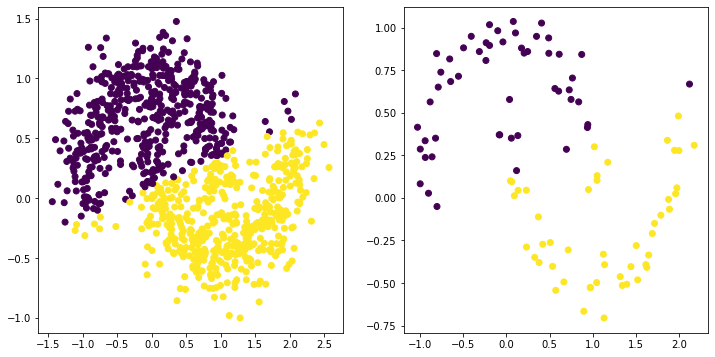

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=np.where(a2[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))

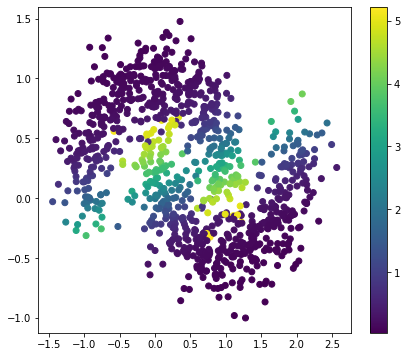

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
im = ax.scatter(X[:, 0], X[:, 1], c=dL_dX[:, 0].abs())
fig.colorbar(im, ax=ax)

what do you think this means?

## Task 4: Training a Neural Network with Pytorch

We will now perform the exact same exercise but using Pytorch's autograd functionality. (我们现在将使用Pytorch的autograd功能执行完全相同的练习。就像在前几个练习中一样，我们可以创建包含所有“层”和“激活函数”的模块。)
Just as in the first few exercises we can create modules that contain all our "layers" and "activations".  
Pytorch then allows us to automatically compute derivatives from the defined computational graph. （然后，Pytorch允许我们从定义的计算图自动计算导数）
Pytorch essentially remembers all the operations that were performed on a dataset, and if you set ```requires_grad=True``` it will compute a gradient with respect to that parameter once you call backward on it. （Pytorch基本上会记住在一个数据集上执行的所有操作，如果您设置requires_grad=True，那么一旦您在该参数上调用backward，它将计算有关该参数的梯度。）
Let's see how this works for our 1-hidden layer neural network.

Here is the general workflow:

- 5.1: Define a SingleHiddenLayer Network as a pytorch module
- 5.2: Define the cost function
- 5.3: Setup the training function
- 5.4: Setup a validation/testing function
- 5.5: Create a training/validation/testing split of your data
- 5.6: Iterate over your dataset (epoch) and train your network using the train() and validate() methods
- 5.7: Make Predictions on the training and test set and plot the results

In [29]:
from torch.utils.data import TensorDataset, DataLoader 

### 4.1: Define a SingleHiddenLayer Network as a pytorch module

In [30]:
class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H, bias=False)
        self.output = nn.Linear(H, O, bias=False)
        self.activation = nn.Sigmoid()
        
    # 即前向传播神经网络
    def forward(self, X):
        z1 = self.hidden_1(X)
        a1 = self.activation(z1)
        z2 = self.output(a1)
        a2 = self.activation(z2)
        return a2

### 4.2: Define the cost function

In [31]:
def bce_loss(y, a2):
    return -1/y.size(0)*(y*a2.log()+(1-y)*(1-a2).log()).sum(0)

### 4.3: Setup the training function

In [32]:
def train(model, optimizer, data_loader):
    model.train()
    for X, y in data_loader:
        optimizer.zero_grad()  # reset gradients
        a2 = model(X)          # forward propagtion through the model
        loss = bce_loss(y, a2) # compute loss
        loss.backward()        # backpropagate
        optimizer.step()       # update model parameters using the gradients
    
    y_pred = np.where(a2[:, 0].detach().numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy

DataLoader class [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

### 4.4: Setup a validation/testing function

In [33]:
def evaluate(model, data_loader):  
    model.eval()
    for X, y in data_loader:
        with torch.no_grad():
            a2 = model(X)
            loss = bce_loss(y, a2)
    y_pred = np.where(a2[:, 0].numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy

### 4.5: Create a training/validation/testing split of your data

In [34]:
#Define the size of the input, hidden, and output layers
I, H, O = 2, 3, 1

#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X_train = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y_train = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

train_dataset = TensorDataset(X_train, y_train) # wrapper around dataset that helps DataLoader

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

test_dataset = TensorDataset(X_test, y_test)

#Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.size(0), shuffle=False)

*NOTE:* TensorDataset in combination with DataLoader helps manage big datasets so that they do not have to be loaded in memory.

### 4.6: Iterate over your dataset (epoch) and train your network using the train() and validate() methods

In [35]:
network = SingleHiddenLayerNetwork(I, H, O) #模型
optim = torch.optim.SGD(network.parameters(), lr=1) # we can pass network.parameters to the optimiser
                                                    # instead of passing an explicit list (useful for big networks)
for i in range(1000):
    train_loss, train_accuracy = train(network, optim, train_loader) #一次迭代（即一整个batch的训练结果）
    test_loss, test_accuracy = evaluate(network, test_loader) #评价这次迭代后优化后的模型
    
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % train_accuracy)
        print("Test Loss in epoch "+str(i)+": %1.2f" % test_loss.item())
        print("Test accuracy in epoch "+str(i)+": %1.2f" % test_accuracy, "\n")

Training Loss in epoch 0: 0.68
Training accuracy in epoch 0: 0.50
Test Loss in epoch 0: 0.68
Test accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.32
Training accuracy in epoch 100: 0.87
Test Loss in epoch 100: 0.32
Test accuracy in epoch 100: 0.85 

Training Loss in epoch 200: 0.30
Training accuracy in epoch 200: 0.88
Test Loss in epoch 200: 0.30
Test accuracy in epoch 200: 0.85 

Training Loss in epoch 300: 0.30
Training accuracy in epoch 300: 0.88
Test Loss in epoch 300: 0.30
Test accuracy in epoch 300: 0.85 

Training Loss in epoch 400: 0.30
Training accuracy in epoch 400: 0.88
Test Loss in epoch 400: 0.29
Test accuracy in epoch 400: 0.85 

Training Loss in epoch 500: 0.30
Training accuracy in epoch 500: 0.88
Test Loss in epoch 500: 0.29
Test accuracy in epoch 500: 0.85 

Training Loss in epoch 600: 0.29
Training accuracy in epoch 600: 0.88
Test Loss in epoch 600: 0.29
Test accuracy in epoch 600: 0.85 

Training Loss in epoch 700: 0.29
Training accuracy in epoch 700: 0.88


After 200 epochs we have converged.

Also note that the loss does not reach a zero value.

### 4.7: Make Predictions on the training and test set and plot the results（对训练集和测试集进行预测，并绘制结果）

Test set accuracy:  0.86


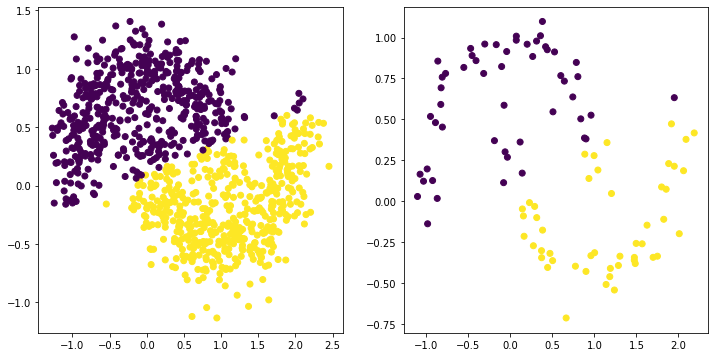

In [ ]:
network.eval()   #   tell the network we are in evaluation mode (deactivates mini-batches, dropouts, etc)
with torch.no_grad():    # deactivates the autograd engine (to not safe grads, etc)
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))

### Looks almost the same as our own backprop results!

[`.eval` documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval)

<br>

-----

<br>

## Additional material: A Pytorch Module for Regression

Pytorch offers a number of modules pre-implemented, many of which we can use for basic and deep neural networks.  
Here we will use a simple linear module to perform linear regression of a dataset of points with Gaussian noise.（Pytorch提供了许多预先实现的模块，其中许多可以用于基本和深层神经网络。 在这里，我们将使用一个简单的线性模块对带有高斯噪声的点的数据集进行线性回归。
）

- 3.1: Use the provided pseudo-code to implement linear regression using gradient descent and pytorch's autograd functionality.

### 3.0: The provided linear regression dataset

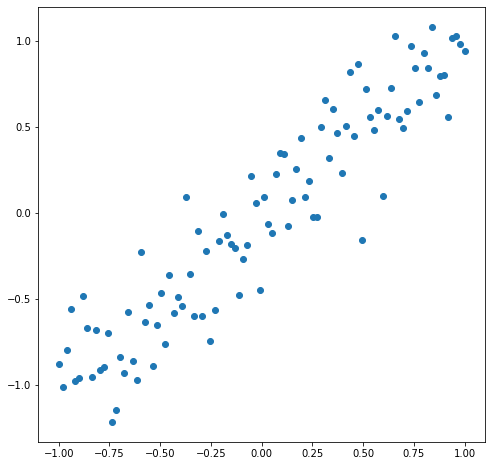

In [36]:
set_seed(42)
x = np.linspace(-1, 1, 100)
y = x + np.random.normal(0, 0.25, size=(100))

x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(x, y)

### 3.1: Use the provided pseudo-code to implement linear regression using gradient descent and pytorch's autograd functionality.

In [ ]:
model = nn.Linear(1, 1, bias=True)
print([(parameter, parameter.size())for parameter in model.parameters()]) # slope term and bias term (2 parameters)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() # now we are defining a loss function we want to minimise
## Pseudo-Code
#iterate over the number of epochs (full data passes)
    #iterate over all the data points
        #reset optimizer gradients
        #predict for current data point the y value ~ model(x)
        #compute the loss by computing the criterion(y_prediction, y_ground_truth)
        #perform backpropagation
        #perform 1 optimizer step
        
#plot the regression line with the original data

[(Parameter containing:
tensor([[0.7645]], requires_grad=True), torch.Size([1, 1])), (Parameter containing:
tensor([0.8300], requires_grad=True), torch.Size([1]))]


You can check the details of the torch.nn.Linear class documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

and the documentation for the torch.nn.MSELoss class (Mean Squared Error, or squared L2 norm) [here](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

### Solution

In [ ]:
model = nn.Linear(1, 1, bias=True)
print([(parameter, parameter.size())for parameter in model.parameters()])

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() # now we are defining a loss function we want to minimise
for iteration in range(100): #iterate over the number of epochs (full data passes)
    total_loss = 0.
    for i, point, value in zip(range(len(x)), x, y): #iterate over all the data points
        optimizer.zero_grad()                        #reset optimizer gradients
        y_ = model(point.view(1, 1))                 #predict for current data point the y value ~ model(x)
        loss = criterion(y_, value.view(1, 1))       #compute the loss by computing the criterion(y_prediction, y_ground_truth)
        loss.backward()                              #perform backpropagation
        optimizer.step()                             #perform 1 optimizer step
        total_loss += loss.item()
    if iteration % 10 == 9 or iteration == 0:
        print("Iteration: ", iteration, "Weight: ", model.weight.data, " Bias: ", model.bias.data, " Loss: ", total_loss/x.size(0))

[(Parameter containing:
tensor([[-0.2343]], requires_grad=True), torch.Size([1, 1])), (Parameter containing:
tensor([0.9186], requires_grad=True), torch.Size([1]))]
Iteration:  0 Weight:  tensor([[-0.1476]])  Bias:  tensor([0.7528])  Loss:  1.2899220986262663
Iteration:  9 Weight:  tensor([[0.3979]])  Bias:  tensor([0.1195])  Loss:  0.21643925250290522
Iteration:  19 Weight:  tensor([[0.7062]])  Bias:  tensor([0.0026])  Loss:  0.08725693993117148
Iteration:  29 Weight:  tensor([[0.8606]])  Bias:  tensor([-0.0177])  Loss:  0.06007026712190736
Iteration:  39 Weight:  tensor([[0.9385]])  Bias:  tensor([-0.0228])  Loss:  0.05332671944158904
Iteration:  49 Weight:  tensor([[0.9779]])  Bias:  tensor([-0.0247])  Loss:  0.051624994081485055
Iteration:  59 Weight:  tensor([[0.9979]])  Bias:  tensor([-0.0255])  Loss:  0.051198056617486144
Iteration:  69 Weight:  tensor([[1.0080]])  Bias:  tensor([-0.0259])  Loss:  0.0510929767275978
Iteration:  79 Weight:  tensor([[1.0131]])  Bias:  tensor([-0.0

Why the values of the weights and biases change more significantly than the loss?

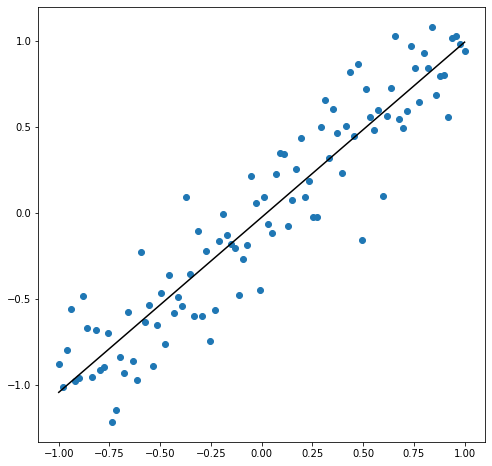

In [ ]:
predictions = [model(point.view(1, 1)) for point in x]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(x, y)
ax.plot(x.numpy(), (model.weight.data.numpy()*x.numpy()+model.bias.data.numpy())[0], c="black")